# Measuring the Jaynes-Cummings Hamiltonian with Qiskit Pulse

### Physics Background

The Jaynes-Cummings model describes a two-level system (qubit) interacting with a single-mode of an electromagnetic cavity (resonator). When a two-level system is placed in a cavity, it couples to the cavity with strength $g$, spontatnously emits its excitation with rate $\gamma$, while the cavity decays with rate $\kappa$.

<img src="images/CQED.png" width="250"/>

This qubit-cavity interaction can be described using the Jaynes-Cummings (JC) Hamiltonian: 

$H_{JC}=\omega_r(a^\dagger a) + \frac{1}{2} \omega_q \sigma_z + g (\sigma_+ a + \sigma_- a^\dagger)$

Let's break down this Hamiltonian in different parts: The first part of the Hamiltonian $H_r=\omega_r(a^\dagger a)$ describes the resonator. The resonator can be treated as a quantum harmonic oscillator, where $\omega_r$ is the resonator frequency, and $a$ and $a^\dagger$ are the raising a lowering operators of the resonator photons. The next term in the JC Hamiltoninan $H_q=\frac{1}{2} \omega_q \sigma_z$ describes the qubit. Here, $\omega_q$ is the qubit frequency, and $\sigma_z$ is the Pauli-Z operator. The final term of the Hamiltonian $H_{rq}=g (\sigma_+ a + \sigma_- a^\dagger)$ describes the interaction between the resonator and the qubit: $g$ is the coupling strength between the qubit and the resonator, and the operators $\sigma_+$ and $\sigma_-$ represent exciting and de-exciting the qubit. Based on this interaction term we can see that the process of exciting a qubit leads to a photon loss in the resonator and vice-versa.

In the limit that detuning between the qubit and the resonator $\Delta=\omega_q-\omega_r$ is less than the coupling strength between the two, $|\Delta|\ll g$, the resonator-qubit system becomes hybridized, leading to coherent excitation swaps which can be useful for certain two-qubit operations. However, for optimal readout, we want to operate the system in the dispersive limit, where the qubit-resonator detuning is much larger than the coupling rate and the resonator decay rate: $|\Delta| \gg g,\kappa$. In this limit the interaction between the qubit and resonator influences each of their frequencies, a feature that can be used for measuring the state of the qubit. We can apply the dispersive approximation in the limit of few photons in the resonator, and approximate the JC Hamiltonian using second-order perturbation theory as: 

$H_{JC(disp)}=(\omega_r+ \chi \sigma_z) a^\dagger a + \frac{1}{2} \tilde{\omega}_q \sigma_z$

where $\chi=-g^2/\Delta$ is the dispersive shift (the negative sign is ue to the fact that the transmon has a negative anharmonicity), and $\tilde{\omega}_q= \omega_q+g^2/\Delta$ is the modified qubit frequency, experiencing a Lamb shift.

In this tutorial we measure the parameters of the JC Hamiltonian for a system consting of a superconducting qubit coupled to a superconducting resonator using Qiskit Pulse.

### 0. Getting started

We'll first get our basic dependencies and helper functions set up and ready to go.

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
backend_defaults = backend.defaults()

In [2]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# process the reflective measurement results
def process_reflective_measurement(freqs,values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)),3,2),freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

# fit a lorentizan function
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmin(values)],(freqs[-1]-freqs[0])/2,min(values),0]
    bounds=([freqs[0],0,-np.inf,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# exponential function
def exponential(t,tau,a,offset):
    return a*np.exp(-t/tau)+offset

# fit an exponential function
def fit_exponential(ts,values):
    p0=[np.average(ts),1,0]
    return curve_fit(exponential, ts, values,p0=p0)

### 1. Measuring $\kappa$

Photons decay out of imperfect electromagnetic cavities. The decay rate $\kappa$ for the resonator cavity can be measured by calculating the linewidth of the resonance peak in a resonator frequency scan. Larger values of $\kappa$ imply that the resonator cavity is more lossy. The resonator loss can be quantified using the quality factor $Q=\omega_r/\kappa$; higher $Q$ indicates a lower rate of energy loss from the cavity.

In [3]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
from qiskit.pulse import pulse_lib
import numpy as np

backend_config = backend.configuration()
dt=backend_config.dt

qubit=0

readout_time = 4e-6
readout_sigma = 10e-9 

# low power drive for the resonator for dispersive readout
readout_drive_low_power=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(readout_time//dt),
                             amp = .3,
                             sigma = get_closest_multiple_of_16(readout_sigma//dt),
                             width = get_closest_multiple_of_16((readout_time-8*readout_sigma)//dt),
                             name = 'low power readout tone')

meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# readout output signal acquisition setup
acquisition_time = readout_time
acquisition=Acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                    channel = acq_chan,
                    mem_slot = pulse.MemorySlot(0))

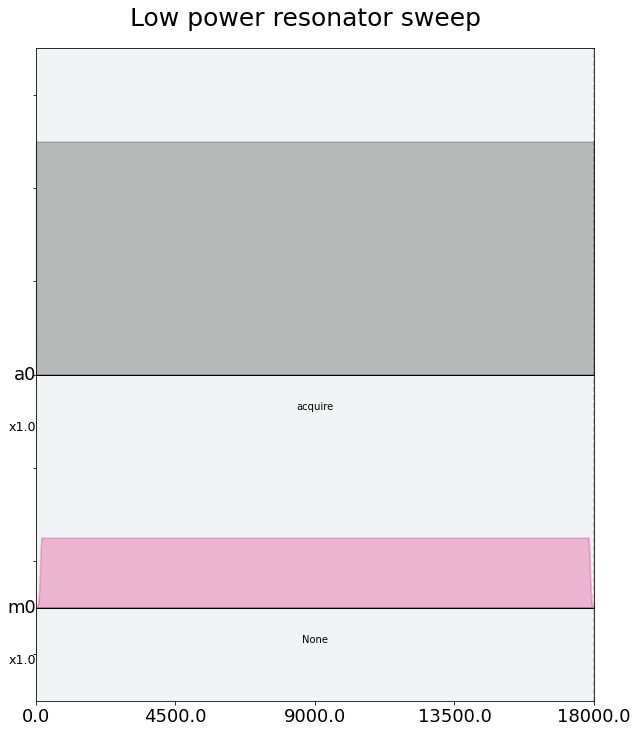

In [4]:
schedule_low_power = pulse.Schedule(name='Low power resonator sweep')
schedule_low_power += Play(readout_drive_low_power, meas_chan) # apply drive pulse to the resonator channel
schedule_low_power += acquisition # aquire the output signal from the resonator readout

schedule_low_power.draw(label=True, scaling=1)

In [25]:
center_freq = backend_defaults.meas_freq_est[qubit]
freq_span = .3e6

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,41)
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

In [26]:
from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots_per_frequency = 2*1024
frequency_sweep_low_power = assemble(schedule_low_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_low_power = backend.run(frequency_sweep_low_power)
job_monitor(job_low_power)

low_power_sweep_results = job_low_power.result(timeout=120)

Job Status: job has successfully run


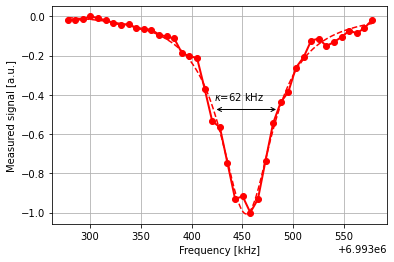

In [27]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results.results)):
    res_low_power = low_power_sweep_results.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.plot(frequencies_range/1e3, low_power_sweep_values,'-o', color='red', lw=2)

popt_low_power,_=fit_lorentzian(frequencies_range,low_power_sweep_values)

popt_low_power,_=fit_lorentzian(frequencies_range,low_power_sweep_values)
f0, kappa, a, offset = popt_low_power

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

### 2. Measuring $\chi$ and $g$

Next, we measure the qubit-resonator coupling. One method for measuring the dispersive shift ($\chi$) and subsequently the qubit-resonator coupling ($g=\sqrt{\chi.\Delta}$) is to compare the resonator frequency in the dispersive limit with the frequency in the non-dispersive regime, where the resonator does not get shifted by $\chi$. In the non-dispersive limit the resonator photon number $n=a^\dagger a$ is larger than $n_c=\frac{\Delta^2}{4g^2}$. In experiment we can populate the resonator with more photons by driving it with more power.

In [28]:
readout_drive_high_power=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(readout_time//dt),
                             amp = 1, # High drive amplitude
                             sigma = get_closest_multiple_of_16(readout_sigma//dt),
                             width = get_closest_multiple_of_16((readout_time-8*readout_sigma)//dt),
                             name = 'high power readout tone')

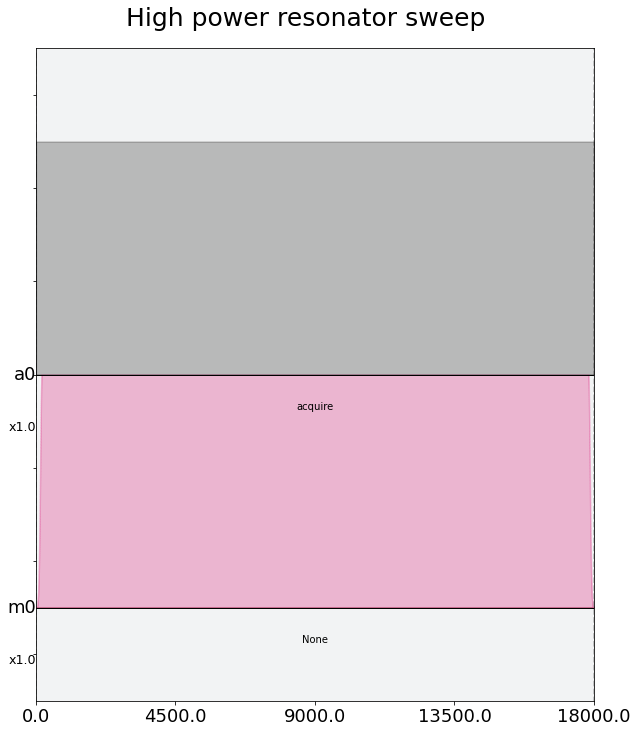

In [29]:
schedule_high_power = pulse.Schedule(name='High power resonator sweep')
schedule_high_power += Play(readout_drive_high_power, meas_chan)
schedule_high_power += acquisition

schedule_high_power.draw(label=True, scaling=1)

In [30]:
frequency_sweep_high_power = assemble(schedule_high_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_high_power = backend.run(frequency_sweep_high_power)
job_monitor(job_high_power)

high_power_sweep_results = job_high_power.result(timeout=120)

Job Status: job has successfully run


In [31]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power,_=fit_lorentzian(frequencies_range,high_power_sweep_values)

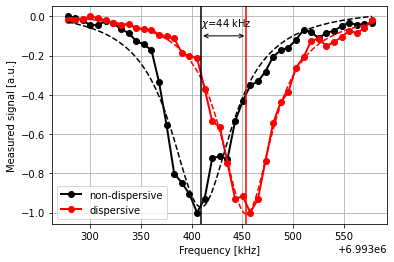

$\chi$=44.6 kHz
$g$=$(\chi \Delta)^.5$=9.5 MHz


In [32]:
plt.plot(frequencies_range/1e3, high_power_sweep_values, '-o', color='black', lw=2, label='non-dispersive')
plt.plot(frequencies_range/1e3, low_power_sweep_values,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')

plt.axvline(x=popt_low_power[0]/1e3, color='red')
plt.axvline(x=popt_high_power[0]/1e3, color='black')

chi=popt_low_power[0]-popt_high_power[0]
plt.annotate("", xy=(popt_low_power[0]/1e3, -.1), xytext=(popt_high_power[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'$\chi$={:.1f} kHz'.format((popt_low_power[0]-popt_high_power[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'$g$=$(\chi \Delta)^.5$={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

### 3. Measuring $\gamma$

A qubit coupled to a resonator will spontaneous emit photons into the cavity, and therefore relaxing from an excited state to the ground state. The spontaneous emission of photons gets enhanced by the qubit environment, a phenomenon known as the Purcell effect. We can measure the qubit decay rate $\gamma$ by exciting the qubit with a microwave drive, and measuring the decay rate $T_1=1/\gamma$ of the qubit excitation. For this experiment our microwave drive doesn't have to be $\pi$-pulse 

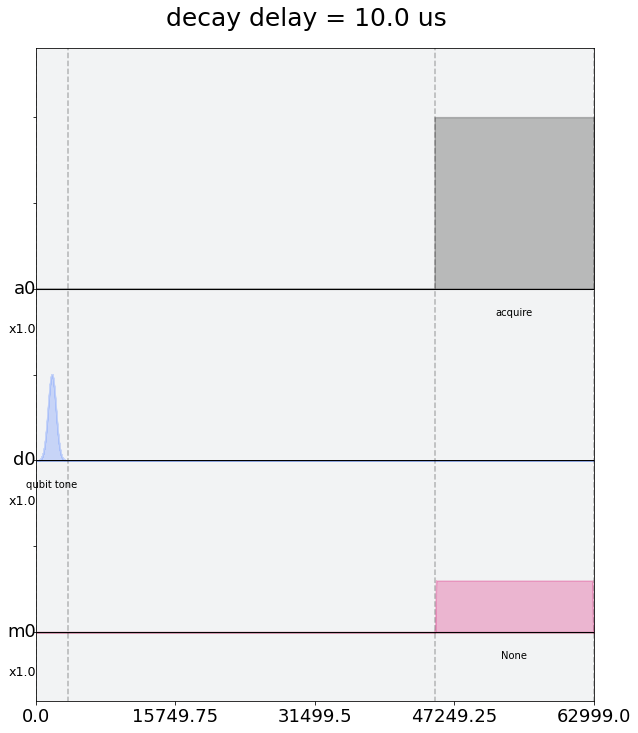

In [39]:
drive_sigma = 100e-9
drive_duration = 8*drive_sigma

# qubit micrwave drive
qubit_drive = pulse_lib.gaussian(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = .5,
                             sigma = get_closest_multiple_of_16(drive_sigma//dt),
                             name = 'qubit tone')

drive_chan = pulse.DriveChannel(qubit)

delay_times=np.linspace(0,600e-6,61) #measurement time delays
qubit_decay_schedules = []
for delay in delay_times:
    this_schedule = pulse.Schedule(name=f"decay delay = {delay * 1e6} us")
    this_schedule += Play(qubit_drive, drive_chan)
    this_schedule |= Play(readout_drive_low_power, meas_chan) + acquisition << int(delay//dt)
    qubit_decay_schedules.append(this_schedule)

qubit_decay_schedules[1].draw(label=True, scaling=1)

In [40]:
# setting the readout frequency to the resontor frequecy in the dispersive limit measured earlier
# setting the qubit freqency to the default value
los = [{meas_chan: f0, drive_chan: backend_defaults.qubit_freq_est[qubit]}]

num_shots = 4*1024

qubit_decay_experiment = assemble(qubit_decay_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los= los * len(qubit_decay_schedules))

job_qubit_decay = backend.run(qubit_decay_experiment)
job_monitor(job_qubit_decay)

Job Status: job has successfully run


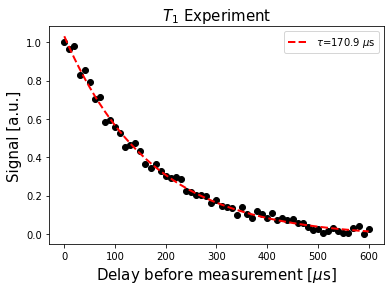

$\gamma$= 1/$\tau$= 5.85 kHz


In [41]:
qubit_decay_results = job_qubit_decay.result(timeout=120)

qubit_decay_values = []
for i in range(len(delay_times)):
    qubit_decay_values.append(qubit_decay_results.get_memory(i)[qubit])
qubit_decay_values = np.abs(qubit_decay_values)
qubit_decay_values = (qubit_decay_values-min(qubit_decay_values))
qubit_decay_values/=max(qubit_decay_values)

decay_popt,_=fit_exponential(delay_times, qubit_decay_values)
tau=decay_popt[0]
g=1/tau

plt.scatter(delay_times*1e6, qubit_decay_values, color='black') 
plt.plot(delay_times*1e6,exponential(delay_times,*decay_popt),'--',lw=2,color='red',label=r'$\tau$={:.1f} $\mu$s'.format(tau*1e6))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

print(r'$\gamma$= 1/$\tau$= {:.2f} kHz'.format(g/1e3))

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

[1] Krantz, P. et al. A quantum engineer’s guide to superconducting qubits. Appl. Phys. Rev. 6, 021318 (2019).